## Relation between Language and (Job Satisaction and Salary)

Our Questions to answer are:
1. Which Language gives you the most job satisfaction?
2. Which Language is paid best?

### Add modules to sys.path

Throughout this notebook we may use some custom functions defined outside of this notebook. To be able to import and use them in this notebook we append the root directory of the project that this notebook belongs to to the system path. 

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT_DIR = Path() / '..'
sys.path.append(str(PROJECT_ROOT_DIR))

# now we can do, for example: "from utils import plot_utils" to import the plot_utils module present in the utils package.

### Data Preparation

To answer them we first load the public survey data (https://insights.stackoverflow.com/survey) of 2017 into a DataFrame

In [2]:
from pathlib import Path

import pandas as pd


DATA_DIR = PROJECT_ROOT_DIR / 'data'
FILE_NAME_2017 = 'survey_results_public_2017.csv'

df_2017 = pd.read_csv(str(DATA_DIR / FILE_NAME_2017))
df_2017.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Besides the id column (*Respondent*), the columns of our interest are:
- *HaveWorkedLanguage* (Which of the following languages have you done extensive development work in over the past year, and which do you want to work in over the next year?)
- *JobSatisfaction* (Overall, how satisfied are you with your current job? (range from 0 to 10; 0 = “Not at all satisfied”; 10 = “Completely satisfied”))
- *Salary* (What is your current annual base salary, before taxes, and excluding bonuses, grants, or other compensation?)

We can drop the rows with NaN values for *HaveWorkedLanguage* since they do not hold any information relevant for our questions of interest.  

In [3]:
df = df_2017[['Respondent', 'HaveWorkedLanguage', 'JobSatisfaction', 'Salary']]
df = df[df['HaveWorkedLanguage'].notna()]
df.describe()

,Respondent,JobSatisfaction,Salary
count,36625.000000,30342.000000,12128.000000
mean,26469.044587,6.991629,56976.397274
std,15380.964842,2.137999,39771.716431
min,1.000000,0.000000,0.000000
25%,12871.000000,6.000000,27272.727273
50%,26781.000000,7.000000,50537.634409
75%,40841.000000,8.000000,80000.000000
max,51392.000000,10.000000,197000.000000


In [4]:
df.head()

,Respondent,HaveWorkedLanguage,JobSatisfaction,Salary
0,1,Swift,NaN,NaN
1,2,JavaScript; Python; Ruby; SQL,NaN,NaN
2,3,Java; PHP; Python,9.0,113750.0
3,4,Matlab; Python; R; SQL,3.0,NaN
5,6,JavaScript; PHP; Rust,NaN,NaN


As we can see above, there is one difficulty with the *HaveWorkedLanguage* column. Instead of just one value it is also possible that it contains a list of semicolon-separted values. So speaking in relational database terms, we have data in an unnormalized form (UNF). To handle that we will turn it into the first normal form (1.NF) by creating an own row for every of the semicolon-separted values.

In [5]:
df = df.assign(HaveWorkedLanguage=df['HaveWorkedLanguage'].str.split(';')).explode('HaveWorkedLanguage')
df['HaveWorkedLanguage'] = df['HaveWorkedLanguage'].apply(lambda x: str(x).strip())
df.head(10)

,Respondent,HaveWorkedLanguage,JobSatisfaction,Salary
0,1,Swift,NaN,NaN
1,2,JavaScript,NaN,NaN
1,2,Python,NaN,NaN
1,2,Ruby,NaN,NaN
1,2,SQL,NaN,NaN
2,3,Java,9.0,113750.0
2,3,PHP,9.0,113750.0
2,3,Python,9.0,113750.0
3,4,Matlab,3.0,NaN
3,4,Python,3.0,NaN


### Question 1 & Question 2 for all data

Now we can compute the average *JobSatisfaction* and *Salary* per *HaveWorkedLanguage*. As we can see from the DataFrame's head the *JobSatisfaction* and *Salary* coulumns have a lot of NaN values (also see the `df.describe()` call earlier). Because we are interested in computing/aggregating the mean for that columns (per *HaveWorkedLanguage*) we need to drop the NaN values since they do not hold valuable information for us. But this also means that our results do not represent all Respondents since we discard their NaN responses. In case of *JobSatisfaction* this does not seem too bad because most Respondents answered this question. But in case of *Salary* only about a third of the repondents gave an non NaN answer.

In [6]:
df_for_avg_job_satisfaction = df[['HaveWorkedLanguage', 'JobSatisfaction']].dropna()
job_satisfaction_per_lang = df_for_avg_job_satisfaction.groupby('HaveWorkedLanguage').mean().reset_index()
job_satisfaction_per_lang.head()

,HaveWorkedLanguage,JobSatisfaction
0,Assembly,7.053004
1,C,6.975518
2,C#,6.984731
3,C++,7.016707
4,Clojure,7.026786


In [7]:
df_for_avg_salary = df[['HaveWorkedLanguage', 'Salary']].dropna()
salary_per_lang = df_for_avg_salary.groupby('HaveWorkedLanguage').mean().reset_index()
salary_per_lang.head()

,HaveWorkedLanguage,Salary
0,Assembly,54449.536221
1,C,56663.800770
2,C#,58305.499895
3,C++,58690.262754
4,Clojure,77494.043705


We know have the data we need to answer our two questions from the beginning. Let's scale it and put it in a nice chart.

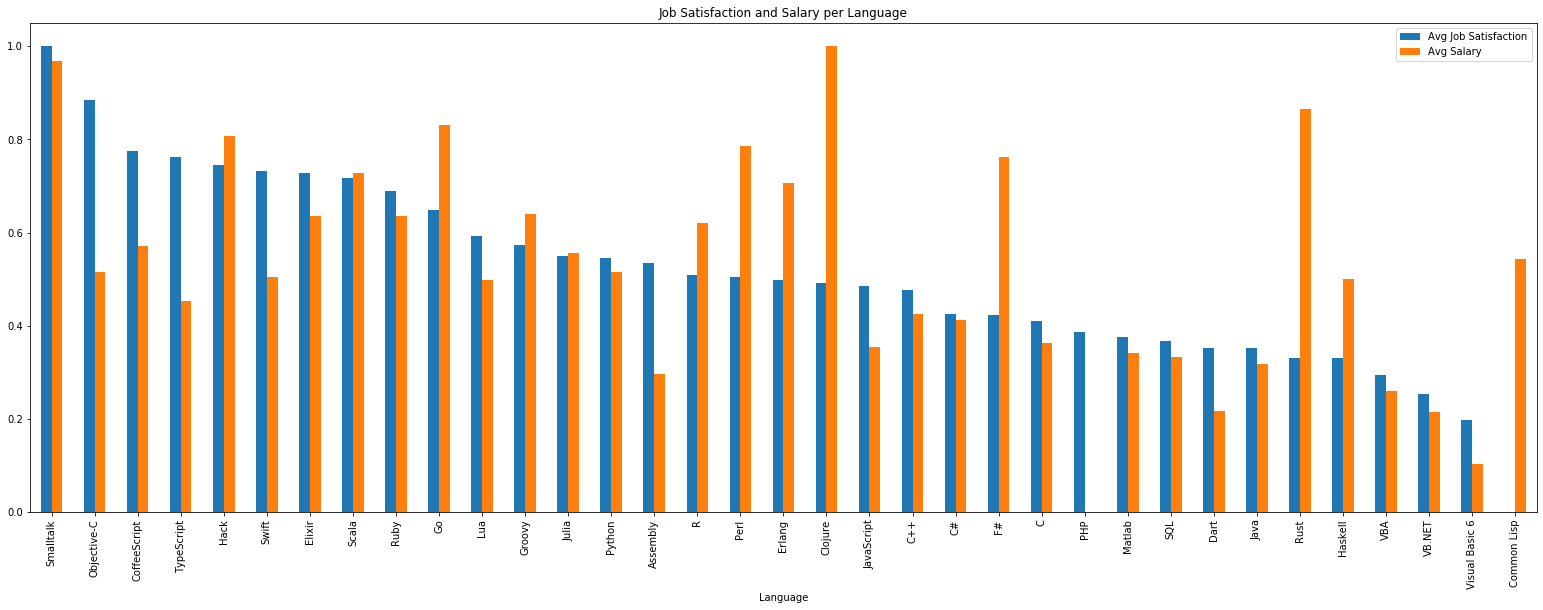

In [8]:
from pandas import DataFrame
from sklearn import preprocessing

from utils import plot_utils


chart_df = DataFrame()
chart_df['Language'] = job_satisfaction_per_lang['HaveWorkedLanguage']
chart_df['Avg Job Satisfaction'] = preprocessing.minmax_scale(job_satisfaction_per_lang['JobSatisfaction'])
chart_df['Avg Salary'] = preprocessing.minmax_scale(salary_per_lang['Salary'])


plot_utils.plot_df(df=chart_df,
                   title='Job Satisfaction and Salary per Language',
                   figsize=(27, 9),
                   column_to_sort_by='Avg Job Satisfaction',
                   ascending=False)


### Question 1 and Question 2 without bottom 4% of popularity

The chart above is not very concise. Therefore, we disregard the languages that less than 4% of the developers have worked with last year.

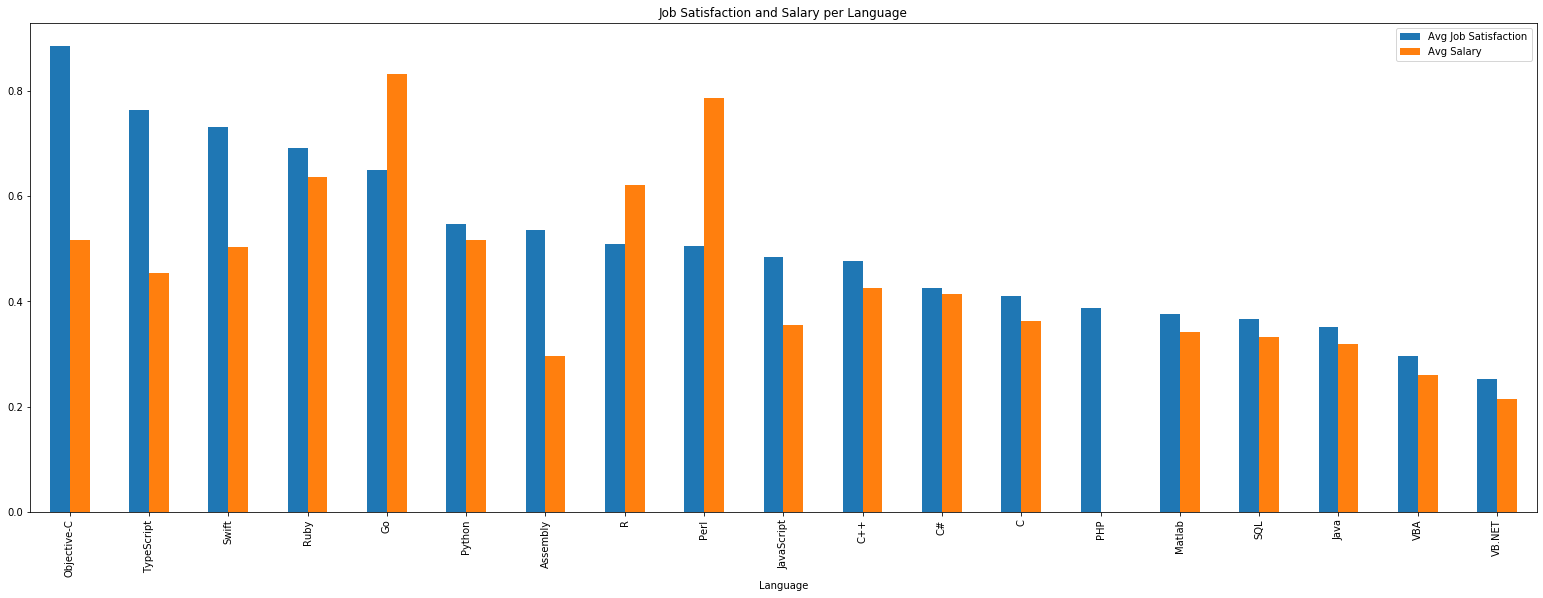

In [9]:
counts_per_lang = df['HaveWorkedLanguage'].value_counts()
percentage_per_lang = counts_per_lang / df['Respondent'].nunique()
to_remove = percentage_per_lang[percentage_per_lang < 0.04].index.tolist()

chart_df = chart_df[~chart_df['Language'].isin(to_remove)]

plot_utils.plot_df(df=chart_df,
                   title='Job Satisfaction and Salary per Language',
                   figsize=(27, 9),
                   column_to_sort_by='Avg Job Satisfaction',
                   ascending=False)
